# Encoder-Decoder Sequence Model

- This tutorial shows how to create a encoder-decoder sequence model for character-based translation.
- The input sequences are English sequences.
- The target sequences are Chinese sequences.

## Set up Dependencies

In [1]:
import tensorflow
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Masking, Embedding, TimeDistributed
import numpy as np

In [2]:
print('Tensorflow Version: ', tensorflow.__version__)

Tensorflow Version:  2.4.1


## DL Hyperparameters

In [3]:
batch_size = 256  # Batch size for training.
epochs = 100 # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
embed_dim = 64

## Data Preprocessing

- Load the data
- Pad the target sequences with sequence-initial and sequence-final characters
- Create dictionary of two languages
- Find max_len and 

In [4]:
# Path to the data txt file on disk.
data_path = '../../../RepositoryData/data/cmn.txt'

# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

# Sort Dictionary
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)

# Find maxinum sent lengths 
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of lines:', len(lines))
print('Number of samples:', len(input_texts))
print('Number of unique input tokens (char):', num_encoder_tokens)
print('Number of unique output tokens (char):', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of lines: 19578
Number of samples: 10000
Number of unique input tokens (char): 73
Number of unique output tokens (char): 2640
Max sequence length for inputs: 31
Max sequence length for outputs: 22


## Keras Processing

### Text to Sequences

In [5]:
## input texts
input_tokenizer = keras.preprocessing.text.Tokenizer(oov_token='UNK', char_level=True, filters=None, lower=False)
input_tokenizer.fit_on_texts(input_texts)
encoder_input_sequences = input_tokenizer.texts_to_sequences(input_texts)
input_maxlen = np.max([len(l) for l in encoder_input_sequences])
encoder_input_sequences = keras.preprocessing.sequence.pad_sequences(encoder_input_sequences, padding='post', maxlen=input_maxlen)

## target texts

target_tokenizer = keras.preprocessing.text.Tokenizer(oov_token='UNK', char_level=True, filters=None, lower=False)
target_tokenizer.fit_on_texts(target_texts)
target_sequences = target_tokenizer.texts_to_sequences(target_texts)
target_maxlen = np.max([len(l) for l in target_sequences])
decoder_sequences = keras.preprocessing.sequence.pad_sequences(target_sequences, padding='post', maxlen = target_maxlen)

In [6]:
# Shapes of Input and Target Sequences
print(encoder_input_sequences.shape)
print(decoder_sequences.shape)

(10000, 31)
(10000, 22)


In [7]:
# ### vocab size
input_vsize = max(input_tokenizer.index_word.keys()) + 1
target_vsize = max(target_tokenizer.index_word.keys()) + 1
print(input_vsize)
print(target_vsize)

75
2642


In [8]:
print(num_encoder_tokens)
print(num_decoder_tokens)

## The differences between the tokenizer vocab size and the num_encoder_tokens
## came from the padding and unknown character

73
2640


### One-hot Encoding

In [9]:
encoder_input_data = keras.utils.to_categorical(encoder_input_sequences, num_classes=input_vsize)
decoder_data = keras.utils.to_categorical(decoder_sequences, num_classes=target_vsize)

decoder_input_data = decoder_data[:, :-1, :]
decoder_target_data = decoder_data[:,1:,:]

In [10]:
print(encoder_input_data.shape)
print(decoder_input_data.shape)
print(decoder_target_data.shape)

(10000, 31, 75)
(10000, 21, 2642)
(10000, 21, 2642)


### Indices of Word Tokens

In [11]:
reverse_input_char_index = dict(
    (char, i) for char, i in enumerate(input_tokenizer.word_index))

reverse_target_char_index = dict(
    (char, i) for char, i in enumerate(target_tokenizer.word_index))

input_token_index = dict(
    (i, char) for char, i in enumerate(input_tokenizer.word_index))

target_token_index = dict(
    (i, char) for char, i in enumerate(target_tokenizer.word_index))

In [12]:
encoder_input_sequences[0]

array([30,  8, 12,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int32)

In [13]:
encoder_input_data[0,:5,:]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.

## Masking

- When we transform the tokens of the input sequences into one-hot encoding, we padded each sequence to a uniform length. The model however has to be informed that some parts of the input sequence are actually padding and should be ignored.
- This mechanism is **masking**.
- In Keras, there are three ways to introduce input masks:
    - Add a `keras.layers.Masking` layer.
    - Configure a `keras.layers.Embedding` layer with `mask_zero=True`.
    - Pass a `mask` argument manually when calling layers that support this argument (e.g. RNN layers).
- In other words, mask-generating layers include `Embedding` and `Masking`

In [14]:
def mask_data(data_onehot, mask_value):
    for i in range(data_onehot.shape[0]):
        for t in range(data_onehot.shape[1]):
            if data_onehot[i, t, 0] == 1.0: 
                data_onehot[i,t,:] = mask_value
    return data_onehot

In [15]:
mask_value = 9999.0

In [16]:
encoder_input_data = mask_data(encoder_input_data, mask_value)
decoder_input_data = mask_data(decoder_input_data, mask_value)
decoder_target_data = mask_data(decoder_target_data, mask_value)

In [17]:
m = keras.layers.Masking(mask_value=mask_value, input_shape=(input_maxlen, input_vsize))
m2 =keras.layers.Masking(mask_value=mask_value, input_shape=(target_maxlen-1, input_vsize))
rnn = keras.layers.SimpleRNN(4,return_sequences=True)

x = encoder_input_data[0:10,:,:]
y = decoder_target_data[0:10,:,:]
x.shape

(10, 31, 75)

In [18]:
m.compute_mask(x)

<tf.Tensor: shape=(10, 31), dtype=bool, numpy=
array([[ True,  True,  True, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False],
       [ True,  True,  True, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False],
       [ True,  True,  True,  True, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False],
       [ True,  True,  True,  True,  True, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, Fals

In [19]:
m2.compute_mask(y)

<tf.Tensor: shape=(10, 21), dtype=bool, numpy=
array([[ True,  True,  True, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False],
       [ True,  True,  True,  True, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False],
       [ True,  True,  True,  True,  True,  True, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False],
       [ True,  True,  True,  True, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False],
       [ True,  True,  True,  True, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False],
       [ True,  True,  True,  True,  True, False, False, False, False,
        False, False, 

In [20]:
rnn(x)

<tf.Tensor: shape=(10, 31, 4), dtype=float32, numpy=
array([[[ 0.14816982, -0.16599253, -0.22141117, -0.06057087],
        [ 0.32000637,  0.26512524,  0.3412334 ,  0.0637099 ],
        [ 0.16340728, -0.04491207, -0.40289825, -0.4774525 ],
        ...,
        [ 1.        ,  1.        ,  1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        ,  1.        ]],

       [[ 0.14816982, -0.16599253, -0.22141117, -0.06057087],
        [ 0.32000637,  0.26512524,  0.3412334 ,  0.0637099 ],
        [ 0.16340728, -0.04491207, -0.40289825, -0.4774525 ],
        ...,
        [ 1.        ,  1.        ,  1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        ,  1.        ]],

       [[-0.05615494, -0.04008067,  0.18389933,  0.17612678],
        [ 0.03687924, -0.4187034 ,  0.18879606, -0.19240986],
        [ 0.34884685,  0.03837245,  0.22668396,  

In [21]:
xm = m(x)
y3 = rnn(xm) 

In [22]:
y3

<tf.Tensor: shape=(10, 31, 4), dtype=float32, numpy=
array([[[ 0.14816982, -0.16599253, -0.22141117, -0.06057087],
        [ 0.32000637,  0.26512524,  0.3412334 ,  0.0637099 ],
        [ 0.16340728, -0.04491207, -0.40289825, -0.4774525 ],
        ...,
        [ 0.16340728, -0.04491207, -0.40289825, -0.4774525 ],
        [ 0.16340728, -0.04491207, -0.40289825, -0.4774525 ],
        [ 0.16340728, -0.04491207, -0.40289825, -0.4774525 ]],

       [[ 0.14816982, -0.16599253, -0.22141117, -0.06057087],
        [ 0.32000637,  0.26512524,  0.3412334 ,  0.0637099 ],
        [ 0.16340728, -0.04491207, -0.40289825, -0.4774525 ],
        ...,
        [ 0.16340728, -0.04491207, -0.40289825, -0.4774525 ],
        [ 0.16340728, -0.04491207, -0.40289825, -0.4774525 ],
        [ 0.16340728, -0.04491207, -0.40289825, -0.4774525 ]],

       [[-0.05615494, -0.04008067,  0.18389933,  0.17612678],
        [ 0.03687924, -0.4187034 ,  0.18879606, -0.19240986],
        [ 0.34884685,  0.03837245,  0.22668396,  

In [23]:
y3= rnn(x, mask = m.compute_mask(x)) 

In [24]:
y3.shape

TensorShape([10, 31, 4])

In [25]:
dense = TimeDistributed(Dense(target_vsize))
dense(y3, mask=m2.compute_mask(y3))[0,0:10,0:20]

<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
array([[-0.00916335,  0.01065375, -0.01683874,  0.00293613, -0.00306671,
        -0.00900294, -0.01325979,  0.00847459,  0.00098329,  0.00260774,
         0.00106453, -0.00344031,  0.00258073, -0.02108549, -0.0107327 ,
         0.01032057,  0.00834448, -0.00095362, -0.0114363 , -0.02187069],
       [ 0.00753907, -0.00324938,  0.00867322, -0.00021645,  0.0217069 ,
         0.00393624,  0.01737534,  0.00599626,  0.00728418, -0.00307482,
        -0.02476303, -0.01224907,  0.01909652,  0.0139475 , -0.00128347,
        -0.00395513,  0.00204056, -0.01693863, -0.0018502 ,  0.01027759],
       [-0.02621715,  0.00676758, -0.0287354 , -0.0222695 , -0.02038768,
        -0.02552703, -0.0286587 ,  0.00960191,  0.01144543,  0.00691038,
        -0.01996661, -0.01753541,  0.00819357, -0.03501952, -0.02013698,
         0.01003911, -0.00467653, -0.00586881, -0.03479849, -0.04502106],
       [-0.02621715,  0.00676758, -0.0287354 , -0.0222695 , -0.02038768

## History Plotting Function

In [26]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
# Plotting results
def plot1(history):

    matplotlib.rcParams['figure.dpi'] = 100
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc)+1)
    ## Accuracy plot
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    ## Loss plot
    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

    
def plot2(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    #plt.gca().set_ylim(0,1)
    plt.show()

## Define Model Architecture Using One-Hot Encoding

- Because this is a sequence (input) to sequence (target) model, we need to define two models:
    - **Encoder**: This is the sequence model to process the input sequences.
    - **Decoder**: This is the sequence model that takes the output of **Encoder** and create the target sequences.

### Encoder

- In the Encoder, it crunches one token (one-hot encoding vector) at a time from the input sequence and output the hidden state and cell state of the last token of the input sequence.
- This output will be the input of the **Decoder**.
- That is, in the LSTM of the Encoder, we only use the hidden states and cell states from the LAST TIME STEP.
- The output of the Encoder is two tensors, from the encoder's LSTM.

In [33]:
## Define Model

## Set up encoder
# Define an input sequence and process it.
encoder_inputs = Input(shape=(input_maxlen, input_vsize)) # one char at a time, with vocab_size dimension, i.e., one-hot encoding
encoder_mask = Masking(mask_value=mask_value, input_shape= (input_maxlen, input_vsize))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs,mask= encoder_mask.compute_mask(encoder_inputs))


# We discard `encoder_outputs` and only keep the states.
## By default, in LSTM, when return_outputs=False, the `encoder_outputs` = `state_h`.
encoder_states = [state_h, state_c] # Two tensors, states_h and states_c, from LSTM

### Decoder

- Now the LSTM of **Decoder** crunches one token at a time from the decoder input sequence.
- The Decoder's LSTM is initialized with the Encoder's output, i.e., the last hidden state and cell state from Encoder's LSTM.
- We then take the all the output hidden states of the Decoder's LSTM and add a dense layer for character prediction.

In [34]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(target_maxlen-1, target_vsize)) # one word at a time, with vocab_size dimension,
decoder_mask = Masking(mask_value=mask_value, input_shape= (target_maxlen-1, target_vsize))

# We set up our decoder to return full output sequences, (i.e, `return_sequences=True`)
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states,
                                     mask= decoder_mask.compute_mask(decoder_inputs))

## softmax the decoder outputs to get prob of target language word
decoder_dense = Dense(target_vsize, activation='softmax')
decoder_time = TimeDistributed(decoder_dense)
decoder_outputs_pred = decoder_time(decoder_outputs, mask = decoder_mask.compute_mask(decoder_inputs))

### Note: This output Dense layer does not need to be wrapped within TimeDistributed.
### because the Dense layer takes in the decoder LSTM's outputs as the inputs.

### In training, the decoder LSTM's inputs would be the entire target sequences
###    and its outputs would be the all the hidden states h's.
###    and Dense Layer softmax all h's into one-hot of the target language characters

### In inferencing, the decoder LSTM's inputs would be one single character of the previous predicted target char
###    and its output would be the all the hidden states h's (but in fact only one becuase intput has only 1 char)
###    and Dense Layer softmax the h into one-hot of the target language character.

In [35]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs_pred)

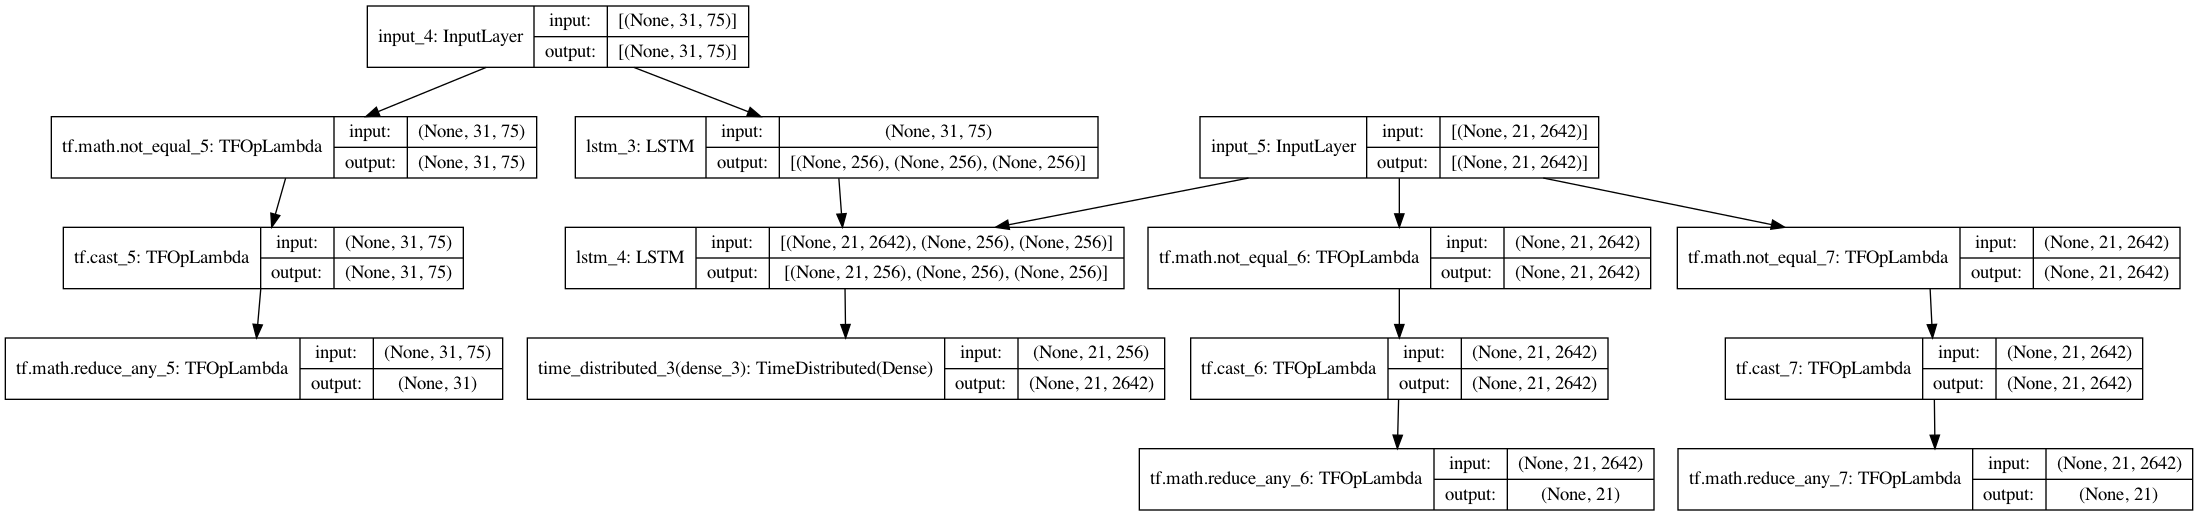

In [36]:
from keras.utils import plot_model

plot_model(model, show_shapes=True)

In [37]:
# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)

Epoch 1/100
17/32 [==============>...............] - ETA: 24s - loss: 9909986.5882 - accuracy: 4.0191e-04

KeyboardInterrupt: 

In [ ]:
plot1(history)

In [ ]:
model.summary()

In [ ]:
ff

## Save and Load Models

### Save Model

In [ ]:
# # Save model
# model.save('keras_models/s2s-cmn.h5')

### Load Trained Model

In [ ]:
## If the model is loaded via external files
## Load the encoder_model, decoder_model this way
from keras.models import load_model
model.load_weights('keras_models/s2s-cmn.h5'')


## Define Inference Model

### Inference Encoder Model

- When using the trained model (Encoder-Decoder), we need to define Encoder and Decoder for inferencing.
- For **Encoder Model**:
    - We use the input layer of the trained model's Encoder, which includes the encoder_input_data (input sequences one-hot)
    - We use the output last_h and last_c from the trained model's Encoder LSTM.
    

In [ ]:
## Create Inference model
encoder_inputs = model.input[0] #input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output # trained encoder's lstm outputs
encoder_states = [state_h_enc, state_c_enc]
encoder_model = Model(encoder_inputs, encoder_states)

In [ ]:
plot_model(encoder_model, show_shapes=True)

### Inference Decoder Model

- For **Decoder Model**:
    - We use the input layer of the trained model's Decoder, which includes the decoder_input_data (target sequences one-hot)
    - We create two more Inputs, representing the Encoder's LSTM output, [last_h and last_c]
    - We use the trained Decoder's LSTM. In the training stage, the decoder LSTM takes in the output of Encoder's last_h and last_c as well as the entire decoder_inputs (complete target sequences). It outputs directly the predicted h's at each time step.
    - But in inferencing stage, the Inference Decoder decodes one token at a time, and returns the predicted h, as well as the last_h and last_c. These last_h and last_c will turn out to be the initial states of the Inference Decoder.

In [ ]:
decoder_inputs = model.input[1] #input_2
decoder_state_input_h = Input(shape=(latent_dim,),name='input_3') # state_h
decoder_state_input_c = Input(shape=(latent_dim,),name='input_4') # state_c
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c] # concat state_h and state_c

decoder_lstm = model.layers[3] ## trained decoder's LSTM

## In training, we use `decoder_ouputs` only.

## In inferencing, we need `decoder_c, and decoder_h`
## because these c and h form the basis for next decoder input
decoder_lstm_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4] ## output Dense Layer
decoder_outputs=decoder_dense(decoder_lstm_outputs)


## Inference Model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs, # target sentence + encoder output h+c
    [decoder_outputs] + decoder_states) # decoder predicted char + decoder predicted h+c

In [ ]:
plot_model(decoder_model, show_shapes=True)

In [ ]:
decoder_model.summary()

### Decode Sequence

- Get the outputs [`last_h`, `last_c`] from the Inference Encoder given the input sequence.
- In the decoding stage, initialize the `target_seq` with `\t` and the initial states of Inference Decoder to be [`last_h`, `last_c`] from Inference Encoder.
- During the decoding stage:
    - Inference Decoder takes in one `target_seq` and [`last_h`, `last_c`] to predict next `target_seq`.
    - At the same time, Inference Decoder returns its [`last_h`, `last_c`].
    - These predicted `target_set` and [`last_h`, `last_c`] are recycled to be the inputs of next-round Inference Decoder.


In [ ]:
def decode_sequence(input_seq):
    
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq) # output: [encoder_last_h, encoder_last_c]

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    
    
    # Within the WHILE-LOOP
    ## Update `target_seq`, `states_value, i.e., [h,c]`
    while not stop_condition:
        # inference starts at the first target char
        # first target char + encoder output h + c
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        ## Choose the output char of the argmax prob
        ## one-hot decode the char and append to the `decoded_sentence`
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        ## everytime the target_seq is the cur_t char, one char a time
        ## the shape should be [1, ,1 vocab_size]
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        ## the h and c output from decoder at cur_t
        states_value = [h, c]

    return decoded_sentence

### Try Inference Decoder

In [ ]:
for seq_index in range(20):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

## End-to-End Implementation

In [ ]:
## in_texts: a list of input sequences
def trans(in_texts):
    ## Input tensor dimensions: [input_batch_size, input_sequence_length, input_vecob/char_size]
    in_texts_onehot = np.zeros(
        (len(in_texts), max_encoder_seq_length, num_encoder_tokens),
     
        dtype='float32')
    
    ## Ont-hot encoding in_texts
    for i, text in enumerate(in_texts):
        ## One-hot encode input_text
        for t, char in enumerate(text):
            in_texts_onehot[i, t, input_token_index[char]] = 1.
        ## End of encoder_input_data
        in_texts_onehot[i, t + 1:, input_token_index[' ']] = 1. 
    
    # Char Holder
    target_texts = []
    
    
    ## Decoding Sequence
    for seq_index in range(len(in_texts)):
        input_seq = in_texts_onehot[seq_index: seq_index + 1]
        target_texts.append(decode_sequence(input_seq))
    
    
    return target_texts

In [ ]:
trans(['How are you?', 'Ok!', 'Hurry!',"How's the weather?", "My name is Alvin."])

## References

- Character-based machine translation using seq-to-seq model
- This is based on keras official code example:[Character-level recurrent sequence-to-sequence model](https://keras.io/examples/nlp/lstm_seq2seq/)
- Other useful tutorials:
    - [Day 18:機器翻譯(Machine Translation](https://ithelp.ithome.com.tw/articles/10194403)
- Machine Translation Datasets: 
    - [English to French sentence pairs](http://www.manythings.org/anki/fra-eng.zip)
    - [Paired Datasets of Other languages](http://www.manythings.org/anki/)
- Readings
    - [Sequence to Sequence Learning with Neural Networks](https://arxiv.org/abs/1409.3215)
    - [Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation](https://arxiv.org/abs/1406.1078)

## Manual Processing

### Token Indices

In [ ]:
# Create char index dictionary
## char as the key and index as the value
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

In [ ]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

In [ ]:
input_token_index.get('H')

In [ ]:
reverse_input_char_index

In [ ]:
input_token_index

In [ ]:
reverse_input_char_index.get(28)

### One-Hot Encoding of Tokens in Sequences

- For each token of the input and target sequences, convert it into a one-hot encoding vector.
- The size of the one-hot vector is the vocabulary size of the input/target language.

In [ ]:
## Text to One-Hot Encoding

## Input Data Shape, 3D: (batch_size, max_encoder_seq_length, num_encoder_tokens)

# Initialize encoder/decoder
## Both input output are three dimensional tensors,
## consisting of each sentence, with all words encoded in one-hot.

## Input tensor dimensions: [input_batch_size, input_sequence_length, input_vecob/char_size]
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')

## Output tensor dimensions: [output_batch_size, output_sequence_length, output_vecob/char_size]
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

In [ ]:
print(encoder_input_data.shape)
print(decoder_input_data.shape)
print(decoder_target_data.shape)

In [ ]:
print(input_texts[:10])
print(target_texts[:10])

In [ ]:
input_texts_len = [len(i) for i in input_texts]

In [ ]:
input_texts_len[np.argmax(input_texts_len)]

In [ ]:
# One-hot encode input and output texts
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    
    ## One-hot encode input_text
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    
    ## End of encoder_input_data
    encoder_input_data[i, t + 1:, input_token_index[' ']] = 1. 
#     encoder_input_data[i,t+1:,:] = -1.0
#     encoder_input_data[i,t+1:t+2,input_token_index[' ']] = 1.0
    
    ## One-hot encode target_text
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        
        # When t > 0, this is the starting character of decoder_target_data
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    
    ## End of decoder_input_data and decoder_output_data
    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
    decoder_target_data[i, t:, target_token_index[' ']] = 1.
#     decoder_input_data[i, t+1:, :] = -1.
#     decoder_target_data[i, t:, :] = -1.



In [ ]:
input_texts[0]
len(input_texts[0])

In [ ]:
## Check input
[reverse_input_char_index.get(np.argmax(i)) for i in encoder_input_data[0]]

In [ ]:
target_texts[0]

In [ ]:
print(len(target_texts[0]))

In [ ]:
np.argmax(decoder_input_data[0, 9,:])

In [ ]:
[reverse_target_char_index.get(np.argmax(i)) for i in decoder_input_data[0]]

In [ ]:
## Check output
[reverse_target_char_index.get(np.argmax(i)) for i in decoder_target_data[0]]

In [ ]:
# check  sequence
print([reverse_input_char_index.get(np.argmax(i)) for i in list(encoder_input_data[0,:,:])])
print([reverse_target_char_index.get(np.argmax(i)) for i in list(decoder_input_data[0,:,:])])
print([reverse_target_char_index.get(np.argmax(i)) for i in list(decoder_target_data[0,:,:])])


In [ ]:
encoder_input_data[0,0:10,:]

### Text-to-Sequences Encoding

In [ ]:
## Text to Sequence
## Input Data Shape: 2D; (Batch_size, max_encoder_seq_length)
## Input tensor dimensions: [input_batch_size, input_sequence_length, input_vecob/char_size]
encoder_input_data_sequence = np.zeros(
    (len(input_texts), max_encoder_seq_length),
    dtype='float32')

## Output tensor dimensions: [output_batch_size, output_sequence_length, output_vecob/char_size]
decoder_input_data_sequence = np.zeros(
    (len(input_texts), max_decoder_seq_length),
    dtype='float32')
decoder_target_data_sequence = np.zeros(
    (len(input_texts), max_decoder_seq_length),
    dtype='float32')

In [ ]:
## Text to Sequences
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    
    ## One-hot encode input_text
    for t, char in enumerate(input_text):
        encoder_input_data_sequence[i, t] = input_token_index[char]
    
    ## End of encoder_input_data
#     encoder_input_data_seqeunce[i, t:t + 1, input_token_index[' ']] = 1. 

    ## One-hot encode target_text
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data_sequence[i, t] = target_token_index[char]
        
        # When t > 0, this is the starting character of decoder_target_data
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data_sequence[i, t - 1] = target_token_index[char]
    
    ## End of decoder_input_data and decoder_output_data
    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
    decoder_target_data[i, t:, target_token_index[' ']] = 1.
#     decoder_input_data[i, t+1:, :] = -1.
#     decoder_target_data[i, t:, :] = -1.
#     decoder_input_data[i, t:t+1, target_token_index[' ']] = 1.
#     decoder_target_data[i, t, target_token_index[' ']] = 1.


In [ ]:
encoder_input_data_sequence[0:10,:]